# Analysis

The EEG was recorded using 256 channels. However, certain channels were identified as potentially noisy or prone to artifact contamination, and we used only a subset of 204 channels for the analysis. The channels we used are shown in the figure below.

<Figure size 640x480 with 0 Axes>

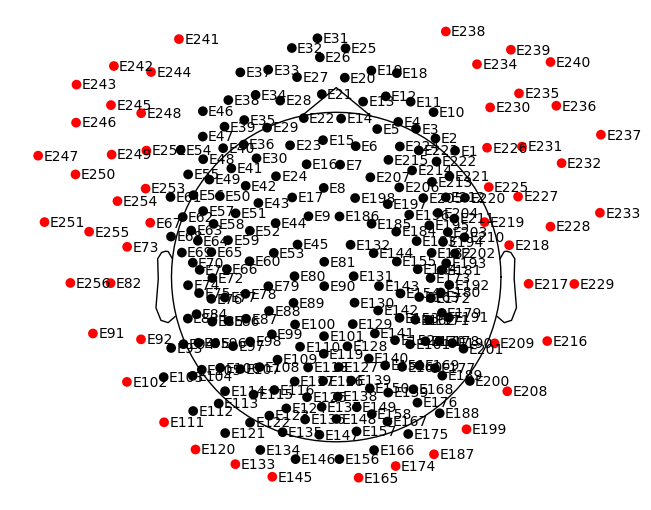

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt

dropped_channels = [
    "E67",
    "E73",
    "E82",
    "E91",
    "E92",
    "E102",
    "E111",
    "E120",
    "E133",
    "E145",
    "E165",
    "E174",
    "E187",
    "E199",
    "E208",
    "E209",
    "E216",
    "E217",
    "E218",
    "E219",
    "E225",
    "E226",
    "E227",
    "E228",
    "E229",
    "E230",
    "E231",
    "E232",
    "E233",
    "E234",
    "E235",
    "E236",
    "E237",
    "E238",
    "E239",
    "E240",
    "E241",
    "E242",
    "E243",
    "E244",
    "E245",
    "E246",
    "E247",
    "E248",
    "E249",
    "E250",
    "E251",
    "E252",
    "E253",
    "E254",
    "E255",
    "E256",
]

montage = mne.channels.make_standard_montage("GSN-HydroCel-256")
info = mne.create_info(montage.ch_names, sfreq=1000, ch_types="eeg")
evoked = mne.EvokedArray(np.random.random((len(montage.ch_names), 1000)), info)
evoked.set_montage(montage)
evoked.info["bads"] = dropped_channels  # replace with your bad channels

# Plot the montage with bad channels
fig = plt.figure()
sensors = evoked.plot_sensors(
    kind="topomap", show_names=True, show=True, sphere=(0.009, -0.013, 0.00, 0.079)
)
plt.show()

EEG  data were analysed using MNE Python (@gramfort2013MEGEEGData, version 1.7). Data were resemapled to 250 Hz and  notch filtered at 50 Hz to eleminate line power noise. A bandpass filter between 1 and 40 Hz was applied  using FIR filter (firwin2 method). Bad channels were identified using the Python implementation of the Preprocessing Pipeline (PREP, @bigdely-shamlo2015PREPPipelineStandardized), were temporarily excluded from analysis and  later extrapolated after performing Independent Component Analysis (ICA). 

Dataset was epoched into 5s intervals, with 1.5s overlap between epochs (0.75s on each side).
The Autoreject library [@jas2017AutorejectAutomatedArtifact] was used to detect and remove epochs containg  huge artifacts (epochs identified as bad on more than 40% bad channels were discarded). ICA was  performed on the data using a variable number of the components determined by capturing 99% of cumulative variance. The picard method was employed 
with the settings `fit_params=dict(ortho=False, extended=True)`, which aligns with FastICA algorithm utilizing the infomax approach (?need to double check)).
The ICA components were visually inspected and those identified as artifacts  were removed. The data were then reconstructed using the remaining components.

For the further analysis, we computed the power spectral density (PSD) using the Welch method. PSD calculations were performed for each epoch and then averaged across epochs. The specparam algorithm (formerly known as fooof, [@donoghue2020ParameterizingNeuralPower]) was applied with the following parameters: freq_range = [1, 40], peak_width_limits = [1, 6], min_peak_height = 0.15, peak_threshold = 2.0, and max_n_peaks = 6.


Similarly to @mckeown2023TestretestReliabilitySpectral, we  excluded participants with specparam model fits < 0.9 R2 on more than 50% of the channels.

In [3]:
import pandas as pd
from pathlib import Path
import pandas as pd

folder_path = Path(
    "/Users/daniel/Projects/psd-paths/analysis/data/specparam/2024-05-14_specparam"
)  # replace with your folder path
df_list = []

# create a loop
for file_csv in folder_path.glob("*.csv"):
    # load csv file
    df = pd.read_csv(file_csv)
    # add dataframe to the list
    df_list.append(df)
# concatenate all DataFrames
df_all = pd.concat(df_list, ignore_index=True)
df_ap = df_all[["sub_id", "ch", "exponent", "offset", "r_squared"]].drop_duplicates()

display(df_ap)

,sub_id,ch,exponent,offset,r_squared
0,152,E1,2.624587,-6.464257,0.996982
1,152,E2,2.581382,-6.541432,0.997098
2,152,E3,2.476481,-6.791030,0.995207
3,152,E4,2.478057,-6.994996,0.998003
6,152,E5,2.300586,-7.816068,0.995685
...,...,...,...,...,...
23866,109,E220,0.804369,-9.769905,0.951381
23868,109,E221,0.704279,-9.878578,0.943059
23869,109,E222,0.680826,-9.948867,0.939876
23870,109,E223,0.701664,-9.973396,0.948624


In [4]:
import pandas as pd

# Assuming your dataframe is named 'df'
threshold = 0.9
percentage_threshold = 0.5

# Group by 'sub_id' and calculate the percentage of channels with r_squared > threshold
sub_id_percentages = (
    df_ap.groupby("sub_id")["r_squared"]
    .apply(lambda x: (x > threshold).mean())
    .reset_index(name="percentage")
)

# Filter sub_id values where the percentage is greater than percentage_threshold
retained_sub_ids = sub_id_percentages[
    sub_id_percentages["percentage"] > percentage_threshold
]["sub_id"]

# Filter the original dataframe to retain only the rows with retained sub_ids
retained_df = df_ap[df_ap["sub_id"].isin(retained_sub_ids)]

In [5]:
display(sub_id_percentages)
# Assuming your dataframe is named 'sub_id_percentages'
sub_ids_below_threshold = sub_id_percentages[sub_id_percentages["percentage"] < 0.5][
    "sub_id"
]
print(sub_ids_below_threshold.values)

,sub_id,percentage
0,101,1.000000
1,102,0.035714
2,103,0.448276
3,104,0.713514
4,105,1.000000
5,106,0.455446
6,107,0.984848
7,108,0.906863
8,109,0.683168
9,110,0.906863


[102 103 106 124 126 151]


In [8]:
sub_ids_medium_threshold = sub_id_percentages[
    (0.5 < sub_id_percentages["percentage"])
    & (sub_id_percentages["percentage"] <= 0.95)
]["sub_id"]

print(sub_ids_medium_threshold.values)

[104 108 109 110 111 113 118 120 121 129 132 144 145 147 148 150]
